# Trabajo Práctico 2 - Visión por Computadoras I
## Carrera de Especialización En Inteligencia Artificial - Cohorte 17
### Autores:
* Horn, Martín
* Lloveras, Alejandro

---
▪ **Objetivo:** Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

---

### Tareas:

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
    de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
    donde se detecta la condición de máximo enfoque.
    
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de forma automática.

**Puntos extra:** Aplicar unsharp masking para expandir la zona de enfoque y devolver

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from PIL import Image


### Recursos necesarios

In [ ]:
def show_img(img1, img2):
    
    plt.figure(figsize=(10, 5))

    # primera imagen
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Frame')
    plt.axis('off')

    # segunda imagen
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('ROI')
    plt.axis('off')

    
    plt.tight_layout()
    plt.show()

In [ ]:
def generate_regions(shape, matrix):
    """
    Divide una imagen en una matriz de NxM rectangulos equiespaciados.

    Parametros:
    - Shape: image_shape, dimensiones de la imagen (altura, ancho).
    - Matrix: matriz NxM con que se segmentara la imagen.

    Salida:
    - Regiones en las que se la imagen. 
    """
    N, M = matrix
    height, width = shape

    rect_height = height // N
    rect_width = width // M

    regions = []
    for i in range(N):
        for j in range(M):
            x1 = j * rect_width
            y1 = i * rect_height
            x2 = x1 + rect_width
            y2 = y1 + rect_height
            regions.append(((x1, y1), (x2, y2)))

    return regions

In [ ]:
def generate_tiles(frame, crop_matrix):
    """
    Divide una imagen en una matriz de NxM rectangulos equiespaciados.

    Parametros:
    - Frame: image, frame a procesar.
    - Crop_Matrix: regiones en las que se segmentara cada frame. 

    Salida:
    - Conjunto de mosaicos de la imagen dividida. 
    """
    tiles = []
    frame = Image.fromarray(frame)

    for region in crop_matrix:
        (x1, y1), (x2, y2) = region

        # cortar el fragmento
        tile = frame.crop((x1, y1, x2, y2))
        tile = np.array(tile)
        # almacenar el fragmento recortado
        tiles.append(tile)

    return tiles

In [ ]:
# importación del video 
def process_Video_Focus(input_path, matrix = (1,1), roi = None):
    """
    Procesa cada frame de un video o una secuencia de imagenes, calcula la metrica
    y la grafica.

    Parámetros:
    - input_path: str, ruta del archivo de video o imagen.

    Salida:
    - Grafico con la evolucion de la metrica de nitidez por frame.
    """

    print("Algoritmo alternativo") if algoritmo_FFT == False else _
    
    cap = cv2.VideoCapture(input_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    shape = (frame_height, frame_width)
    sharpness_values = []

    if not cap.isOpened():
        print("No se pudo abrir el archivo.")
        return
    
    # variables para ROI
    if roi != None:
        print(f"Área de enfoque {roi*100:.0f}% del frame.")

       
        roi_width = int(frame_width * roi)
        roi_height = int(frame_height * roi)
        center_x, center_y = frame_width // 2, frame_height // 2
        x1, y1 = center_x - roi_width // 2, center_y - roi_height // 2
        x2, y2 = center_x + roi_width // 2, center_y + roi_height // 2

    if matrix != (1,1):
        print(f"La imágen será procesada según la Matriz {matrix[0]}x{matrix[1]}")
        crop = generate_regions(shape, matrix)
        print("Completa la creación de regiones")
        print("")
    
    
    frame_index = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        
        if roi != None:
            # calculo para ROI del frame
            roi_frame = frame[y1:y2, x1:x2]
            sharpness = image_Quality_Measure(roi_frame) if algoritmo_FFT == True else modified_dct_focus_measure(roi_frame)
            if frame_index == 0:
                show_img(frame, roi_frame)
        else:
            # calculo para el frame completo
            if matrix == (1,1):
                sharpness = image_Quality_Measure(frame) if algoritmo_FFT == True else modified_dct_focus_measure(frame)
            else:
                sharpness = []
                tiles = generate_tiles(frame, crop)
                # calculo para cada tile del frame
                for tile in tiles:
                    focus_metric = image_Quality_Measure(tile) if algoritmo_FFT == True else modified_dct_focus_measure(tile)
                    sharpness.append(focus_metric)
                #np.array(focus_metrics).reshape(N, M)
                #print(sharpness)

        sharpness_values.append(sharpness)
        frame_index += 1
        # mostrar progreso
        print(f"Procesando frame {frame_index}/{frame_count}", end="\r")

    
    #cap.release()
    cv2.destroyAllWindows()

    sharpness_values = np.transpose(np.array(sharpness_values))
    print()

    return sharpness_values

In [ ]:
def detect_Focus_Peaks(focus_metrics, threshold=0.8, sensibility=0.5):
    """
    Detecta los puntos de maximo enfoque en la serie temporal.
    - height: Proporcion de la altura maxima para considerar un pico.
    - distance: Minima distancia entre picos.
    """
    
    """
    Sensibility 1 = Valor 30 -> detecta solo el máximo global
    Sensibility 0.8 = Valor 20  -> detecta maximos locales
    Sensibility 0.5 = Valor 5/10 -> detecta varios puntos locales
    Sensibility 0 = Valor 1 -> detecta el más minimo incremento
    """
    distance = round(14 * sensibility**3 + 1.4 * sensibility**2 + 14 * sensibility + 1)

    # normalizado de la serie de métricas
    normalized_metrics = focus_metrics / np.max(focus_metrics)
    
    # detectar picos que superen el umbral de altura
    peaks, _ = find_peaks(normalized_metrics, height=threshold, distance=distance)

    return peaks


def graph_Metrics(ism_metrics, sensibility=0.5):
    
    if len(ism_metrics.shape) > 1:
        multi = True
        samples = ism_metrics.shape[0]
    else:
        multi = False
        samples = 0
        focus_peaks = detect_Focus_Peaks(ism_metrics)
        print(f"Picos detectados en los frames: {focus_peaks}")

       
        plt.figure(figsize=(15, 8))
        plt.plot(ism_metrics, label="Métrica de Enfoque", color='blue', alpha=0.6, marker='.', linestyle='-')
        plt.scatter(focus_peaks, ism_metrics[focus_peaks], linewidths = 3, zorder = 2, color='red', s=100, label='Picos de Máximo Enfoque', marker='x')
        plt.title("Evolución de la Métrica de Enfoque")
        plt.xlabel("Frame #")
        plt.ylabel("Métrica de Enfoque (ISM)")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return focus_peaks
    
    focus_peaks = []

    # colores para las curvas
    colors = plt.cm.viridis(np.linspace(0, 1, samples))

    plt.figure(figsize=(15, 8))
    if multi:
        # calcula y detecta picos para la media
        ism_average = np.median(np.transpose(ism_metrics), axis=1)
        focus_peaks_average = detect_Focus_Peaks(ism_average, sensibility)

        plt.plot(
            ism_average, 
            label="Métrica de Enfoque", 
            color='red', 
            alpha=0.6, 
            zorder=3, 
            marker='.', 
            linestyle='-'
        )
        plt.scatter(
            focus_peaks_average, 
            ism_average[focus_peaks_average], 
            linewidths=3, 
            zorder=4, 
            color='red', 
            s=100, 
            label='Picos de Máximo Enfoque',
            marker='x'
        )

        for sample in range(samples):        
        
            metric = ism_metrics[sample]
            focus_peaks = detect_Focus_Peaks(metric, sensibility=0.75)
            print(f"Picos para el {sample} detectados en el frame: {focus_peaks}")
            
            plt.plot(
                metric, 
                #label=f"Métrica Sample {sample}", 
                color=colors[sample], 
                alpha=0.35, 
                marker='', 
                linestyle='-'
            )
            plt.scatter(
                focus_peaks, 
                [metric[i] for i in focus_peaks], 
                linewidths=3, 
                zorder=2, 
                color=colors[sample], 
                alpha=0.7, 
                s=30, 
                label=f'Sample {sample}',
                marker='^'
            )
        print(f"Picos generales detectados en los frames: {focus_peaks_average}")


    plt.title("Evolución de la Métrica de Enfoque")
    plt.xlabel("Frame #")
    plt.ylabel("Métrica de Enfoque (ISM)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return focus_peaks_average

In [ ]:
def draw_matrix(image, matrix, color):
    """
    Visualiza la imagen dividida en NxM regiones con los valores de enfoque superpuestos.
    """
    N, M = matrix
    height, width = image.shape[:2]

    rect_height = (height-1) // N
    rect_width = (width-1) // M

    # Calcular el desplazamiento necesario para centrar la cuadricula
    total_grid_height = rect_height * N
    total_grid_width = rect_width * M

    offset_y = (height - total_grid_height) // 2
    offset_x = (width - total_grid_width) // 2

    overlay = image.copy()
    cv2.rectangle(overlay, (1, 1), (width-2, height-2), color, 2)

    for i in range(N):
        for j in range(M):
            x1 = offset_x + j * rect_width
            y1 = offset_y + i * rect_height
            x2 = x1 + rect_width
            y2 = y1 + rect_height

            
            value = " " #focus_matrix[i, j]
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 1)
            cv2.putText(overlay, f"{value}", (x1 + 10, y1 + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return overlay

In [ ]:
def export_Video(ism_metrics, video_path='focus_video.mov', output_path='output_video.mp4', threshold_focus = 1, roi = None, matrix = None):
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error al abrir el video.")
        return

    
    if not cap.isOpened():
        print("Error al abrir el video.")
        return

    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    print(f"Propiedades del video: {frame_width}x{frame_height}px, {fps}fps")

    
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    
    if not out.isOpened():
        print("Error al crear el archivo de salida.")
        return
    
   
    center_x, center_y = frame_width // 2, frame_height // 2
    max = ism_metrics[np.argmax(ism_metrics)]

    if roi != None:
        # Con ROI
        roi_width = int(frame_width * roi)
        roi_height = int(frame_height * roi)
        center_x, center_y = frame_width // 2, frame_height // 2
        roi_rad = round(math.sqrt(roi_width**2 + roi_height**2) //2 *1.4)

    if matrix != None:
        print(f"La imágen será procesada según la Matriz {matrix[0]}x{matrix[1]}")
    
    frame_count = 0
    norm = ism_metrics[frame_count] / max
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        focus_metric = ism_metrics[frame_count]

        
        if focus_metric > threshold_focus:
            color = (0, 255, 0)  # Verde si está enfocado
        else:
            color = (0, 0, 255)  # Rojo si está desenfocado
        
        if matrix != None:
            frame = draw_matrix(frame, matrix, color)

        # calcular la métrica de nitidez para el frame actual
        if roi != None:
            # Con ROI
            roi_width = int(frame_width * roi)
            roi_height = int(frame_height * roi)
            roi_x1, roi_y1 = center_x - roi_width // 2, center_y - roi_height // 2
            roi_x2, roi_y2 = center_x + roi_width // 2, center_y + roi_height // 2
            cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), color, 1)
            cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), color, 1)
            cv2.circle(frame, (center_x, center_y), roi_rad, color, 1)
            cv2.circle(frame, (center_x, center_y), (roi_rad + 5), color, 1)
        else:    
            # Sin ROI
            rad = frame_height /2 * 0.8
            if frame_count % 3 == 0:
                norm = focus_metric / max
            cv2.circle(frame, (center_x, center_y), round(rad*1.05), color, 1)
            cv2.circle(frame, (center_x, center_y), round(rad*norm), color, 1)

       
        out.write(frame)

        
        cv2.imshow('Frame Procesado', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

   
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Video exportado correctamente en: {output_path}")


## Implementación del algoritmo base

In [ ]:
def image_Quality_Measure(image):
    """
    Calcula la méetrica de enfoque basada en la Transformada de Fourier para un frame dado.
    La metrica mide la energia de las frecuencias altas en el dominio de la frecuencia.
    """
    
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Paso 1: Calcular la Transformada de Fourier
    F = np.fft.fft2(image)
    
    # Paso 2: Centrar la Transformada de Fourier
    Fc = np.fft.fftshift(F)
    
    # Paso 3: Obtener el espectro de magnitud
    AF = np.abs(Fc)
    
    # Paso 4: Calcular el valor máximo en el espectro
    M = np.max(AF)
    
    # Paso 5: Contar los píxeles que superan el umbral (M/1000)
    threshold = M / 1000
    Th = np.sum(AF > threshold)
    
    # Paso 6: Calcular la métrica de nitidez
    sharpness_metric = Th / (image.shape[0] * image.shape[1])
    
    return sharpness_metric

algoritmo_FFT= True

## 1.1. Medición sobre todo el frame

Procesando frame 171/171
Picos detectados en los frames: [ 88  99 109]


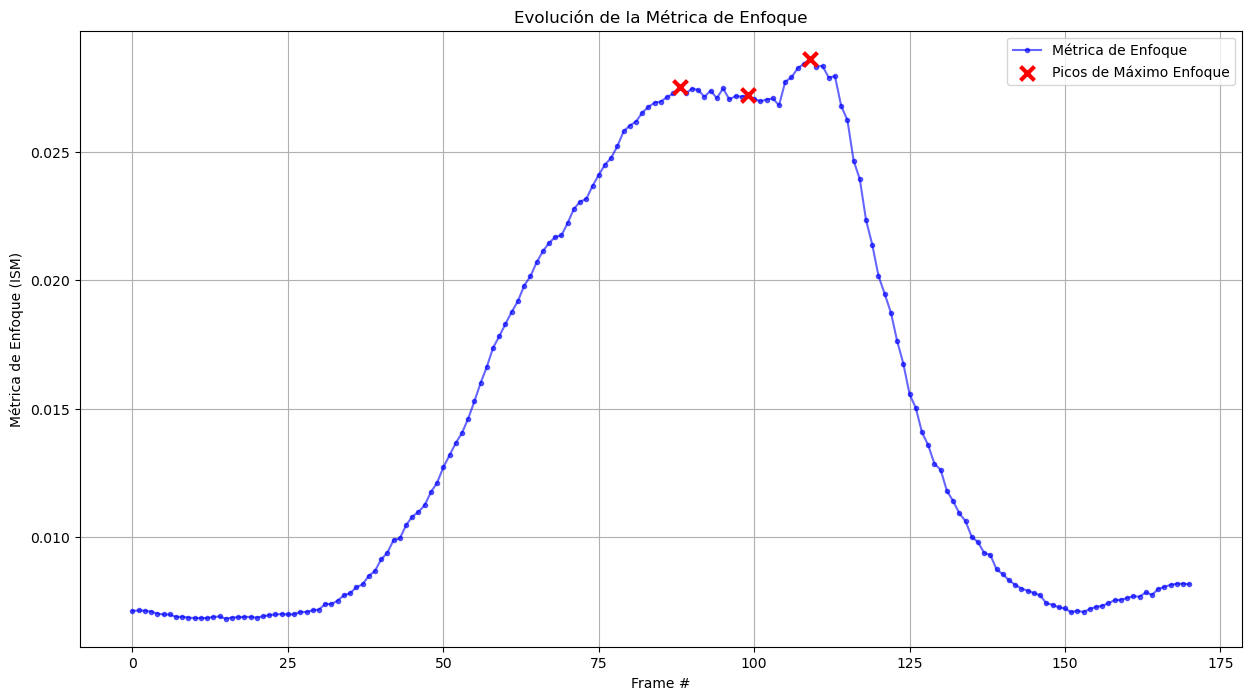

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_metrics[focus_peaks])]
max_peak_value = ism_metrics[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 109 con un valor de 0.02862


In [ ]:

mean = np.mean(ism_metrics[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 0.02778
Threshold del 80% de los picos: 0.02222


In [ ]:
output_path = 'focus_frame.mp4'
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_metrics, output_path=output_path,threshold_focus = level)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
Video exportado correctamente en: focus_frame.mp4


## 1.2. Medición sobre una ROI
ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.


In [ ]:
roi = 5 /100 # ROI del 5 o 10% del área total del frame

Área de enfoque 5% del frame.


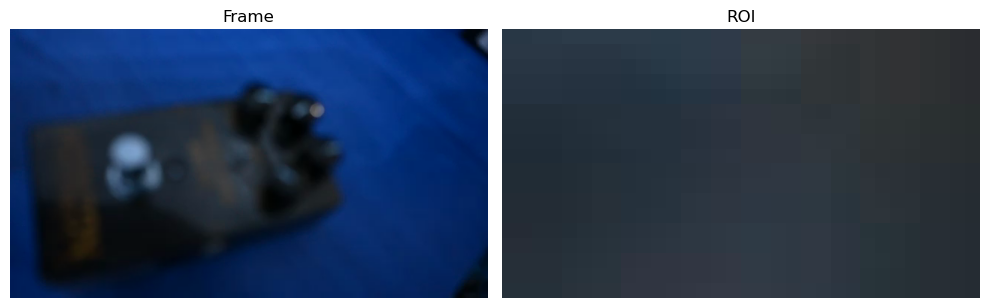

Procesando frame 171/171
Picos detectados en los frames: [ 84  95 105]


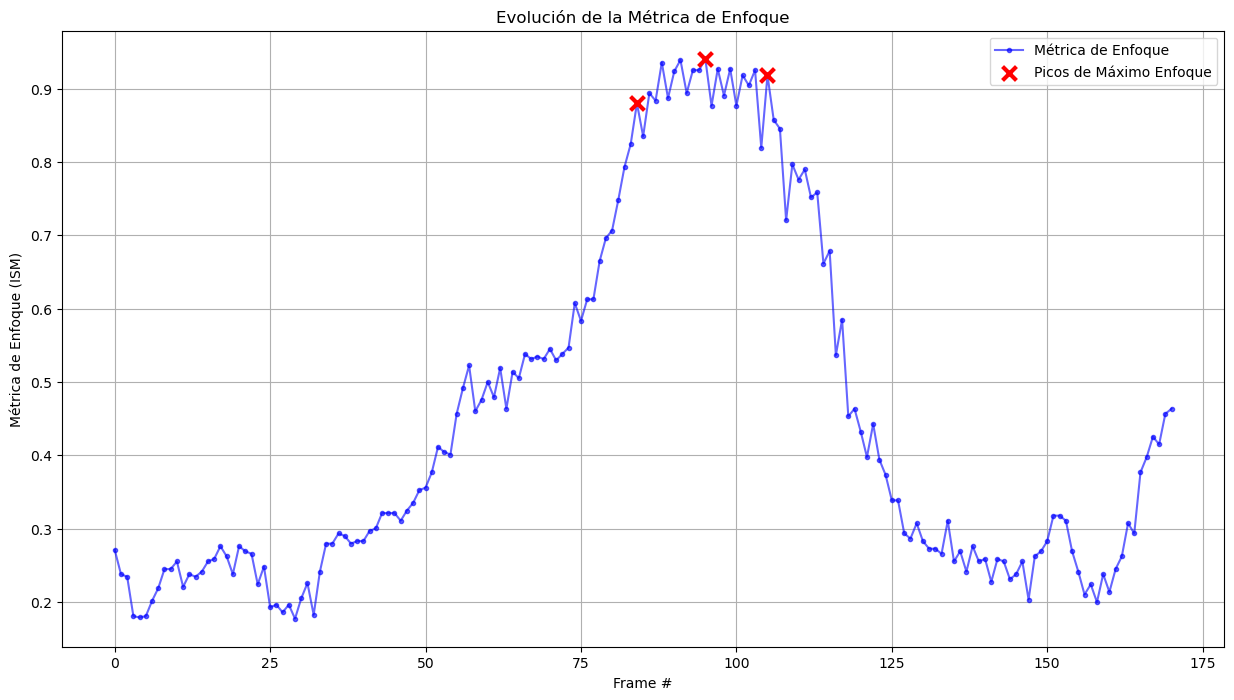

In [ ]:

video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, roi=roi)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_metrics[focus_peaks])]
max_peak_value = ism_metrics[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 95 con un valor de 0.94097


In [ ]:
mean = np.mean(ism_metrics[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 0.91319
Threshold del 80% de los picos: 0.73056


In [ ]:
output_path = f'focus_roi{round(roi*100)}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_metrics, output_path=output_path,threshold_focus = level, roi=roi)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
Video exportado correctamente en: focus_roi5.mp4


## 1.3. Medición sobre una matriz de enfoque
Compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

### Matriz 3x3

In [ ]:
matrix = 3, 3

La imágen será procesada según la Matriz 3x3
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [69]
Picos para el 1 detectados en el frame: [70 93]
Picos para el 2 detectados en el frame: [123]
Picos para el 3 detectados en el frame: [99]
Picos para el 4 detectados en el frame: [105]
Picos para el 5 detectados en el frame: [99]
Picos para el 6 detectados en el frame: [111]
Picos para el 7 detectados en el frame: [109]
Picos para el 8 detectados en el frame: [ 84 117]
Picos generales detectados en los frames: [ 72  99 109 123]


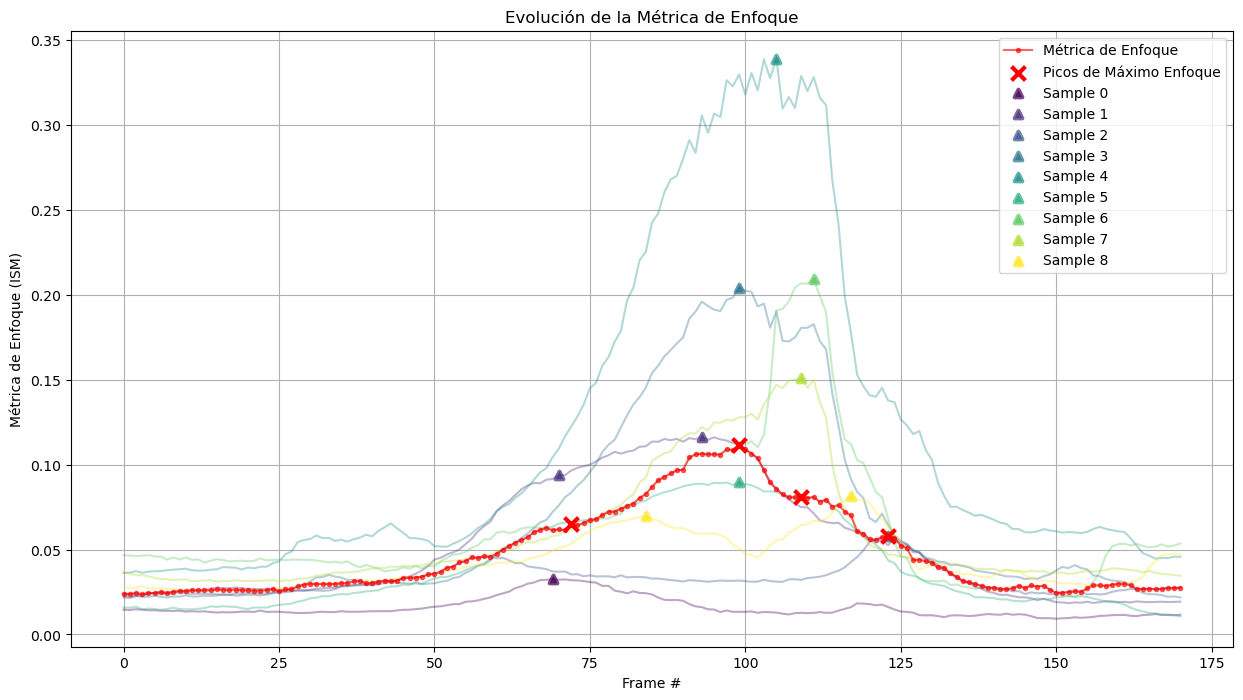

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [37]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 99 con un valor de 0.11158


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 0.07883
Threshold del 80% de los picos: 0.06307


In [ ]:
N, M = matrix
output_path = f'focus_matrix_{N}x{M}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 3x3
Video exportado correctamente en: focus_matrix_3x3.mp4


### Matriz 3x2

In [ ]:
matrix = 3, 2

La imágen será procesada según la Matriz 3x2
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [72 90]
Picos para el 1 detectados en el frame: [72 95]
Picos para el 2 detectados en el frame: [99]
Picos para el 3 detectados en el frame: [105]
Picos para el 4 detectados en el frame: [111]
Picos para el 5 detectados en el frame: [ 82 117]
Picos generales detectados en los frames: [ 95 105]


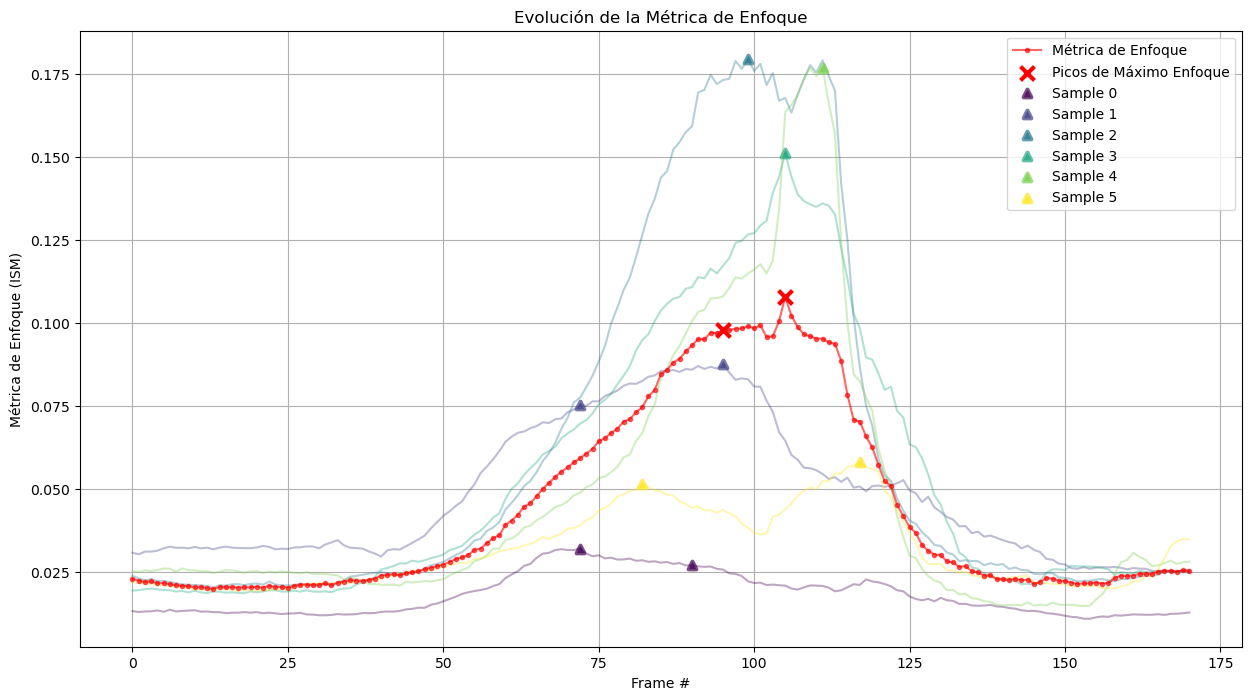

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 105 con un valor de 0.10785


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 0.10285
Threshold del 80% de los picos: 0.08228


In [ ]:
N, M = matrix
output_path = f'focus_matrix_{N}x{M}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 3x2
Video exportado correctamente en: focus_matrix_3x2.mp4


### Matriz 7x5

In [ ]:
matrix = 7, 5

La imágen será procesada según la Matriz 7x5
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [69]
Picos para el 1 detectados en el frame: [ 66 120]
Picos para el 2 detectados en el frame: [64]
Picos para el 3 detectados en el frame: [ 62 121]
Picos para el 4 detectados en el frame: [ 58 123]
Picos para el 5 detectados en el frame: [72]
Picos para el 6 detectados en el frame: [ 71 118]
Picos para el 7 detectados en el frame: [82]
Picos para el 8 detectados en el frame: [62 82]
Picos para el 9 detectados en el frame: [ 61 121]
Picos para el 10 detectados en el frame: [76 95]
Picos para el 11 detectados en el frame: [91]
Picos para el 12 detectados en el frame: [ 86 113]
Picos para el 13 detectados en el frame: [ 59  87 105]
Picos para el 14 detectados en el frame: [ 63 122]
Picos para el 15 detectados en el frame: [ 91 110]
Picos para el 16 detectados en el frame: [99]
Picos para el 17 detectados en el frame: [ 91 111]
Picos para el 18 d

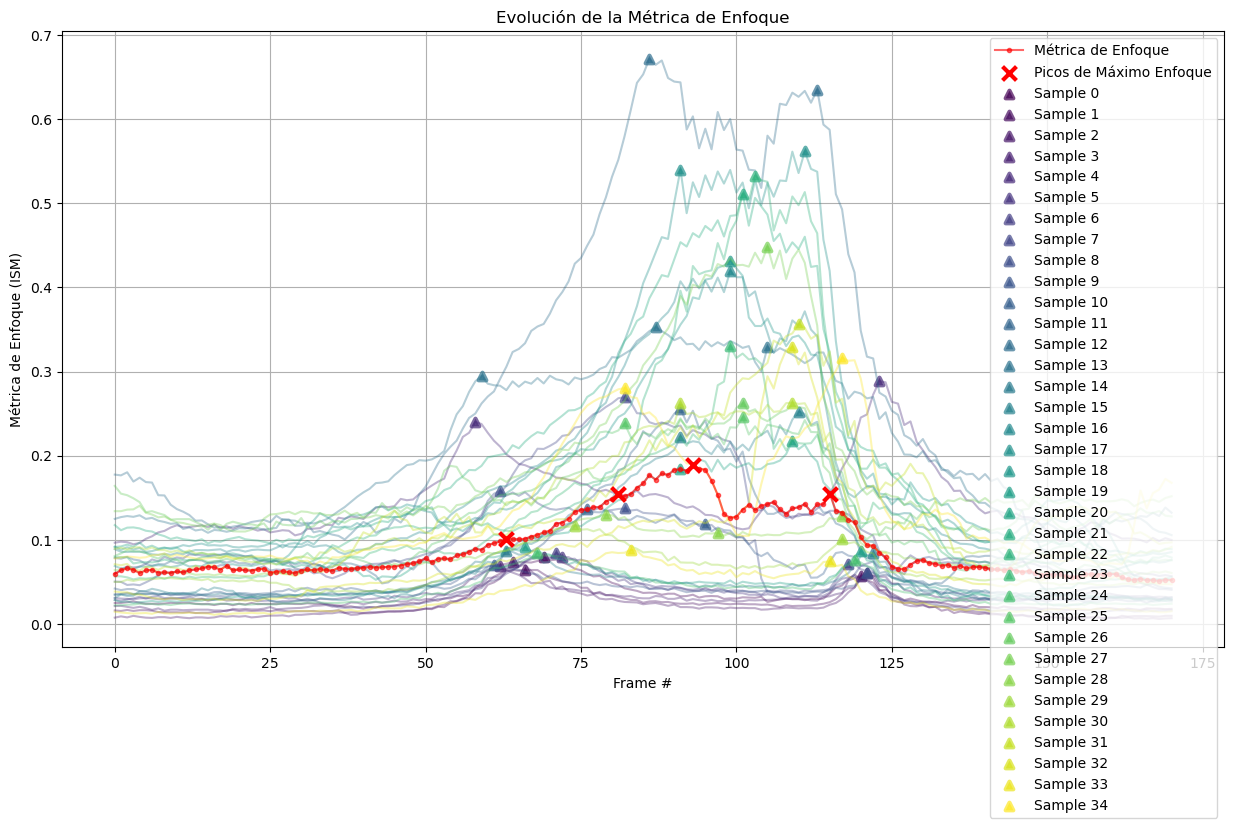

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 93 con un valor de 0.18919


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 0.14978
Threshold del 80% de los picos: 0.11982


In [ ]:
N, M = matrix
output_path = f'focus_matrix_{N}x{M}.mp4'
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 7x5
Video exportado correctamente en: focus_matrix_7x5.mp4


### Matriz 9x13

In [ ]:
matrix = 9, 13

La imágen será procesada según la Matriz 9x13
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [ 68 119]
Picos para el 1 detectados en el frame: [ 68 119]
Picos para el 2 detectados en el frame: [68]
Picos para el 3 detectados en el frame: [ 66 120]
Picos para el 4 detectados en el frame: [ 66 120]
Picos para el 5 detectados en el frame: [66]
Picos para el 6 detectados en el frame: [64]
Picos para el 7 detectados en el frame: [ 61 122]
Picos para el 8 detectados en el frame: [ 62 121]
Picos para el 9 detectados en el frame: [ 59 124]
Picos para el 10 detectados en el frame: [ 58 126]
Picos para el 11 detectados en el frame: [169]
Picos para el 12 detectados en el frame: [ 57 124]
Picos para el 13 detectados en el frame: [72]
Picos para el 14 detectados en el frame: [69]
Picos para el 15 detectados en el frame: [ 68 118]
Picos para el 16 detectados en el frame: [68]
Picos para el 17 detectados en el frame: [ 66 119]
Picos para el 18 dete

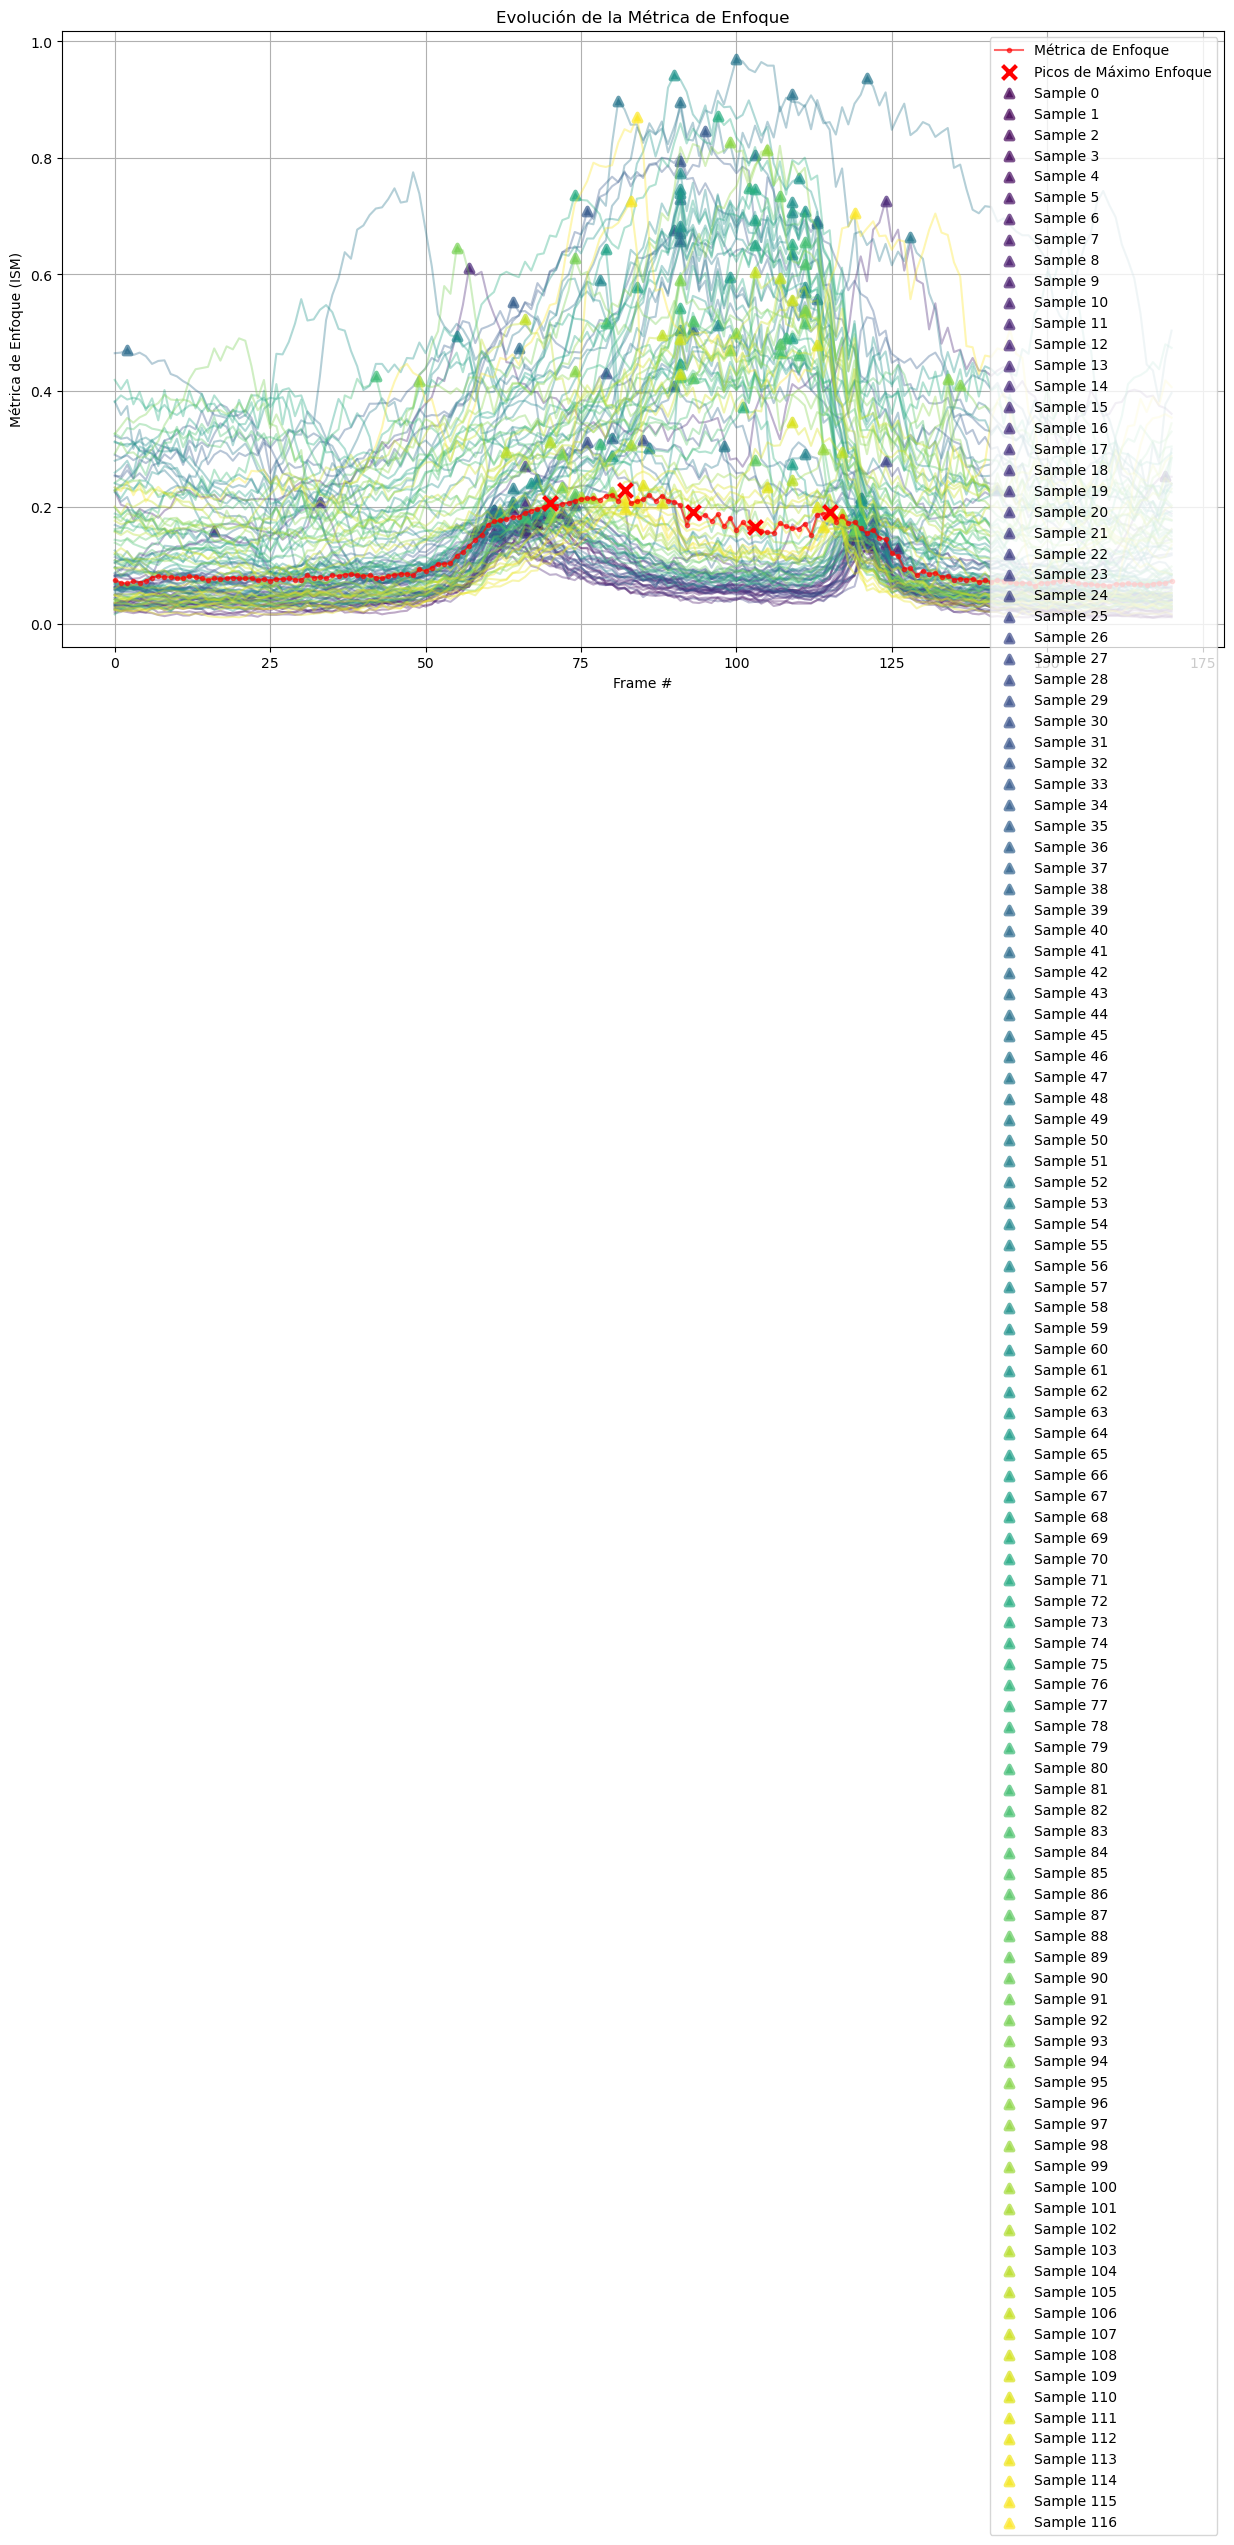

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 82 con un valor de 0.22959


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 0.19714
Threshold del 80% de los picos: 0.15771


In [ ]:
N, M = matrix
output_path = f'focus_matrix_{N}x{M}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 9x13
Video exportado correctamente en: focus_matrix_9x13.mp4


# 2. Algortimo alternativo
Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

## Implementación del algoritmo alternativo

In [ ]:
def modified_dct_focus_measure(image):
    
    M = np.array([
        [1,  1, -1, -1],
        [1,  1, -1, -1],
        [-1, -1,  1,  1],
        [-1, -1,  1,  1]
    ], dtype=np.float32)
    
    # usar la mascara M para realizar una convolucion
    conv_result = cv2.filter2D(image, cv2.CV_32F, M)
    
    
    focus_measure = np.abs(conv_result)
    sharpness_metric = np.mean(focus_measure)
    
    return sharpness_metric

algoritmo_FFT= False

## 2.1. Medición sobre todo el frame

Algoritmo alternativo
Procesando frame 171/171
Picos detectados en los frames: [ 80  90 101 111]


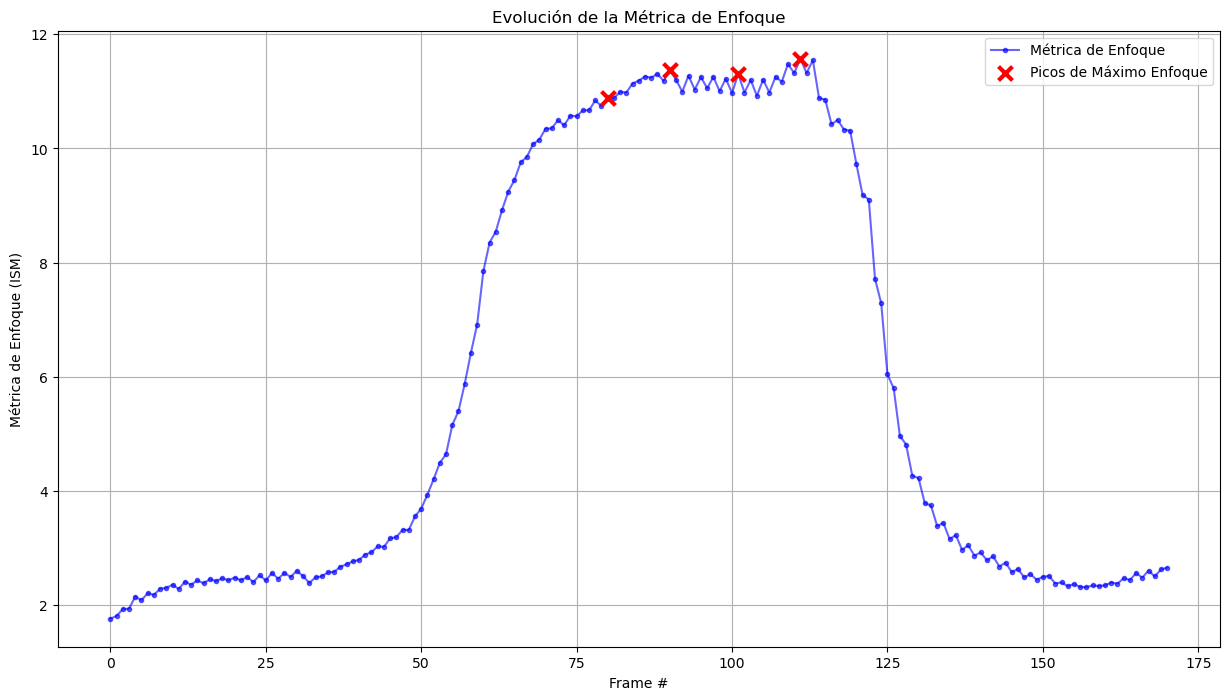

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_metrics[focus_peaks])]
max_peak_value = ism_metrics[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 111 con un valor de 11.57153


In [ ]:
mean = np.mean(ism_metrics[focus_peaks])
threshold = 80 /100 
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 11.28270
Threshold del 80% de los picos: 9.02616


In [ ]:
output_path = 'alt_focus_frame.mp4'
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_metrics, output_path=output_path,threshold_focus = level)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
Video exportado correctamente en: alt_focus_frame.mp4


## 2.2. Medición sobre una ROI
ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.


In [ ]:
roi = 5 /100 # ROI del 5 o 10% del área total del frame

Algoritmo alternativo
Área de enfoque 5% del frame.


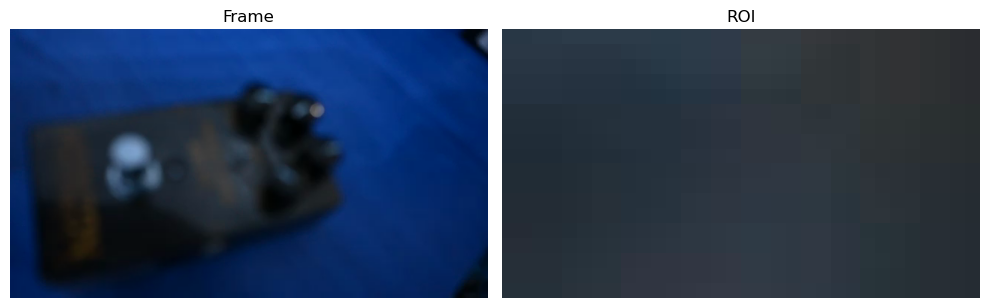

Procesando frame 171/171
Picos detectados en los frames: [ 93 112]


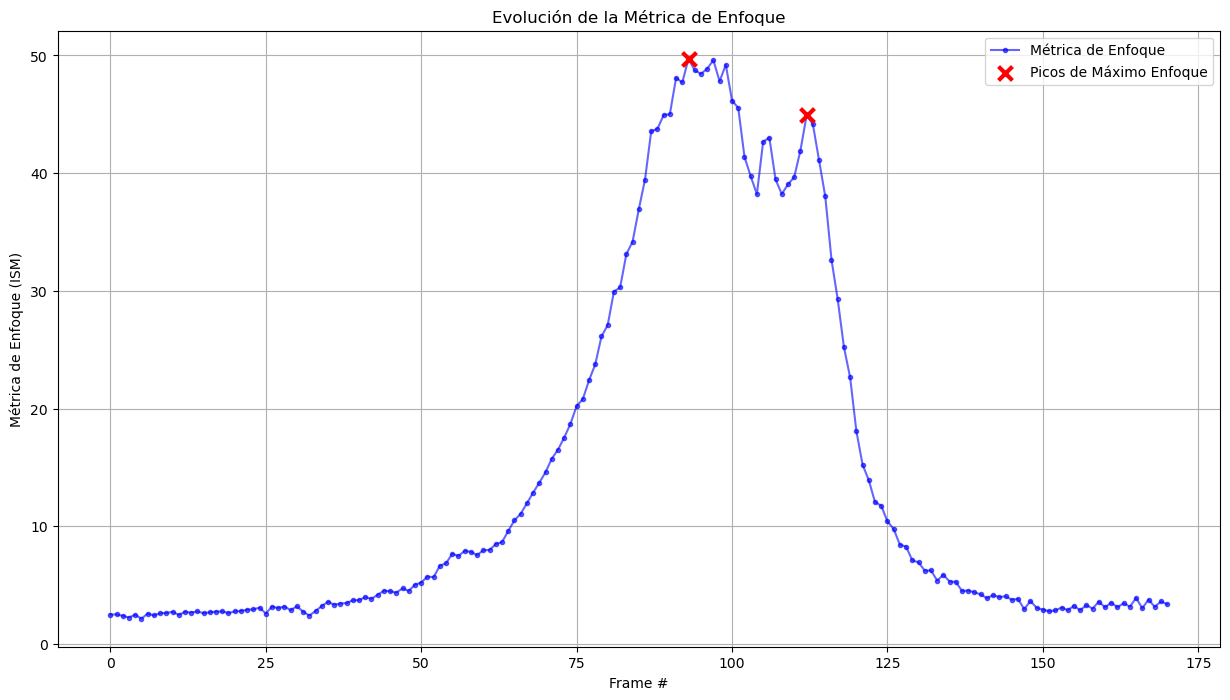

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, roi=roi)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_metrics[focus_peaks])]
max_peak_value = ism_metrics[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 93 con un valor de 49.72512


In [ ]:
mean = np.mean(ism_metrics[focus_peaks])
threshold = 80 /100  
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 47.31858
Threshold del 80% de los picos: 37.85486


In [ ]:
output_path = f'alt_focus_roi{round(roi*100)}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_metrics, output_path=output_path,threshold_focus = level, roi=roi)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
Video exportado correctamente en: alt_focus_roi5.mp4


## 2.3. Medición sobre una matriz de enfoque
Compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

### Matriz 3x3

In [ ]:
matrix = 3, 3

Algoritmo alternativo
La imágen será procesada según la Matriz 3x3
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [ 69 119]
Picos para el 1 detectados en el frame: [ 66 120]
Picos para el 2 detectados en el frame: [ 61 123]
Picos para el 3 detectados en el frame: [ 93 111]
Picos para el 4 detectados en el frame: [ 93 111]
Picos para el 5 detectados en el frame: [ 68 120]
Picos para el 6 detectados en el frame: [111]
Picos para el 7 detectados en el frame: [ 90 109]
Picos para el 8 detectados en el frame: [ 76 117]
Picos generales detectados en los frames: [ 74  86 103 119]


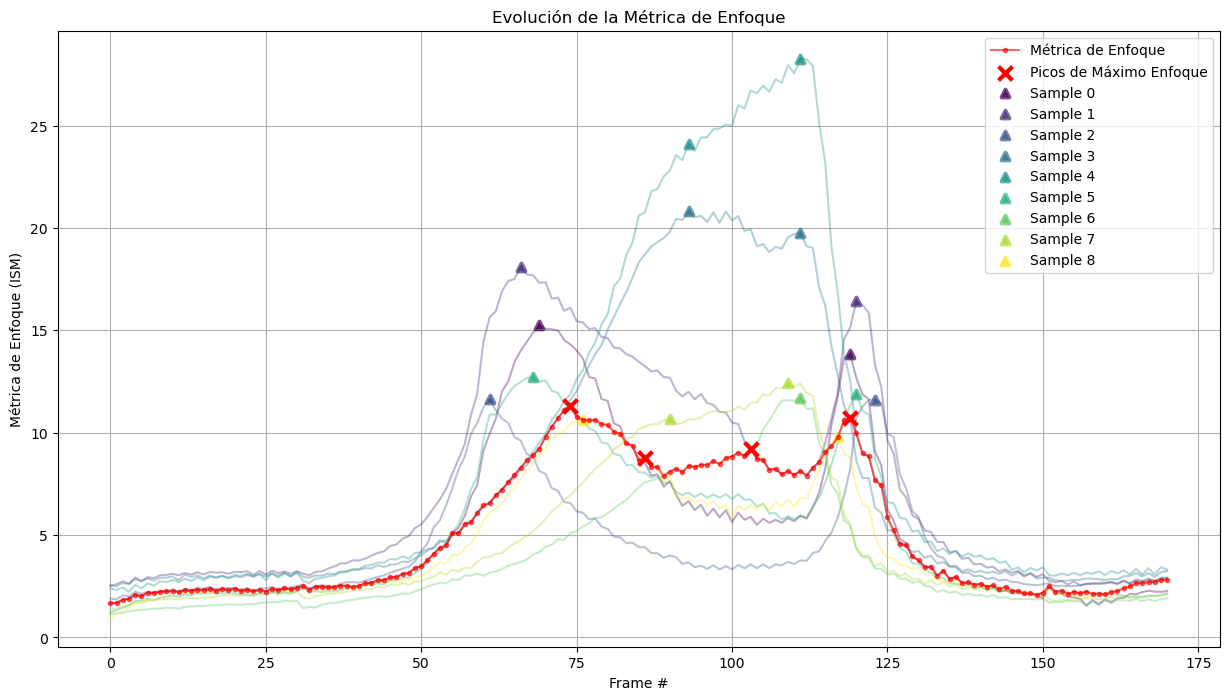

In [ ]:

video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 74 con un valor de 11.28211


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 9.98779
Threshold del 80% de los picos: 7.99023


In [ ]:
N, M = matrix
output_path = f'alt_focus_matrix_{N}x{M}.mp4'
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 3x3
Video exportado correctamente en: alt_focus_matrix_3x3.mp4


### Matriz 3x2

In [ ]:
matrix = 3, 2

Algoritmo alternativo
La imágen será procesada según la Matriz 3x2
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [ 69 119]
Picos para el 1 detectados en el frame: [ 61 122]
Picos para el 2 detectados en el frame: [ 93 111]
Picos para el 3 detectados en el frame: [ 70 105]
Picos para el 4 detectados en el frame: [111]
Picos para el 5 detectados en el frame: [ 78 117]
Picos generales detectados en los frames: [ 72  90 107 117]


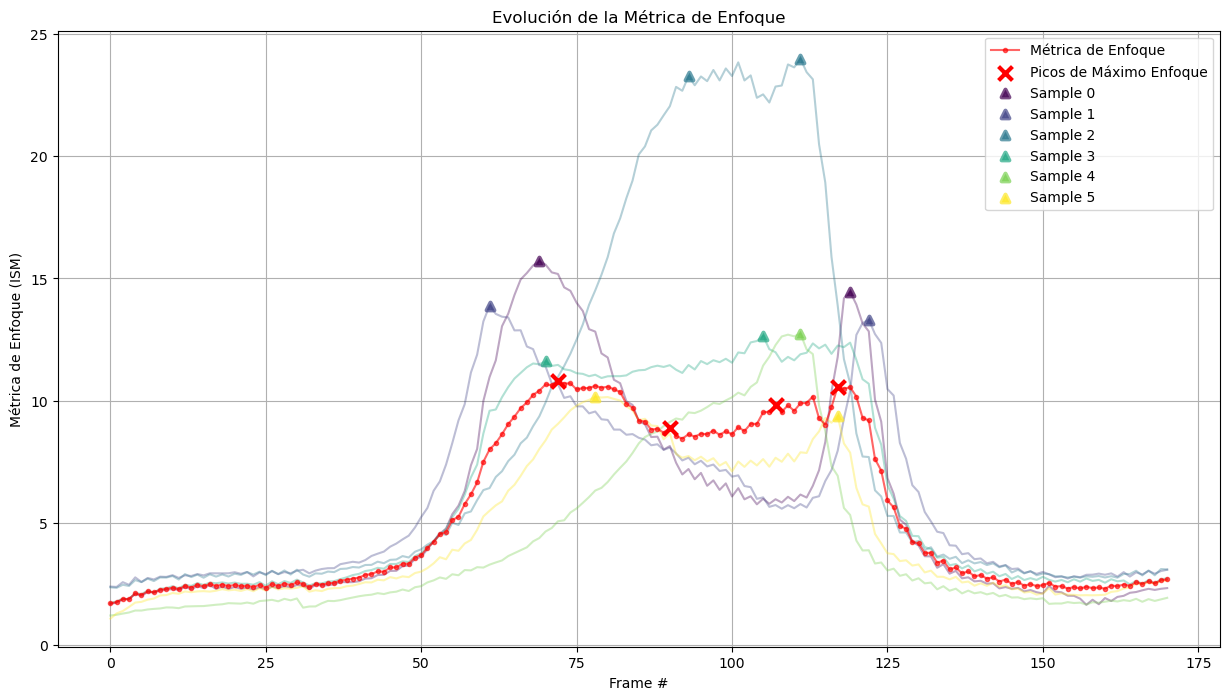

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 72 con un valor de 10.82216


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 10.02720
Threshold del 80% de los picos: 8.02176


In [ ]:
N, M = matrix
output_path = f'alt_focus_matrix_{N}x{M}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 3x2
Video exportado correctamente en: alt_focus_matrix_3x2.mp4


### Matriz 7x5

In [ ]:
matrix = 7, 5

Algoritmo alternativo
La imágen será procesada según la Matriz 7x5
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [ 69 119]
Picos para el 1 detectados en el frame: [ 67 120]
Picos para el 2 detectados en el frame: [ 64 122]
Picos para el 3 detectados en el frame: [ 61 123]
Picos para el 4 detectados en el frame: [124]
Picos para el 5 detectados en el frame: [ 75 118]
Picos para el 6 detectados en el frame: [ 70 118]
Picos para el 7 detectados en el frame: [ 70 120]
Picos para el 8 detectados en el frame: [ 61 121]
Picos para el 9 detectados en el frame: [ 61 124]
Picos para el 10 detectados en el frame: [ 80 117]
Picos para el 11 detectados en el frame: [ 89 116]
Picos para el 12 detectados en el frame: [ 87 113]
Picos para el 13 detectados en el frame: [ 68  90 120]
Picos para el 14 detectados en el frame: [ 61 122]
Picos para el 15 detectados en el frame: [ 91 111]
Picos para el 16 detectados en el frame: [92]
Picos para el 17 detec

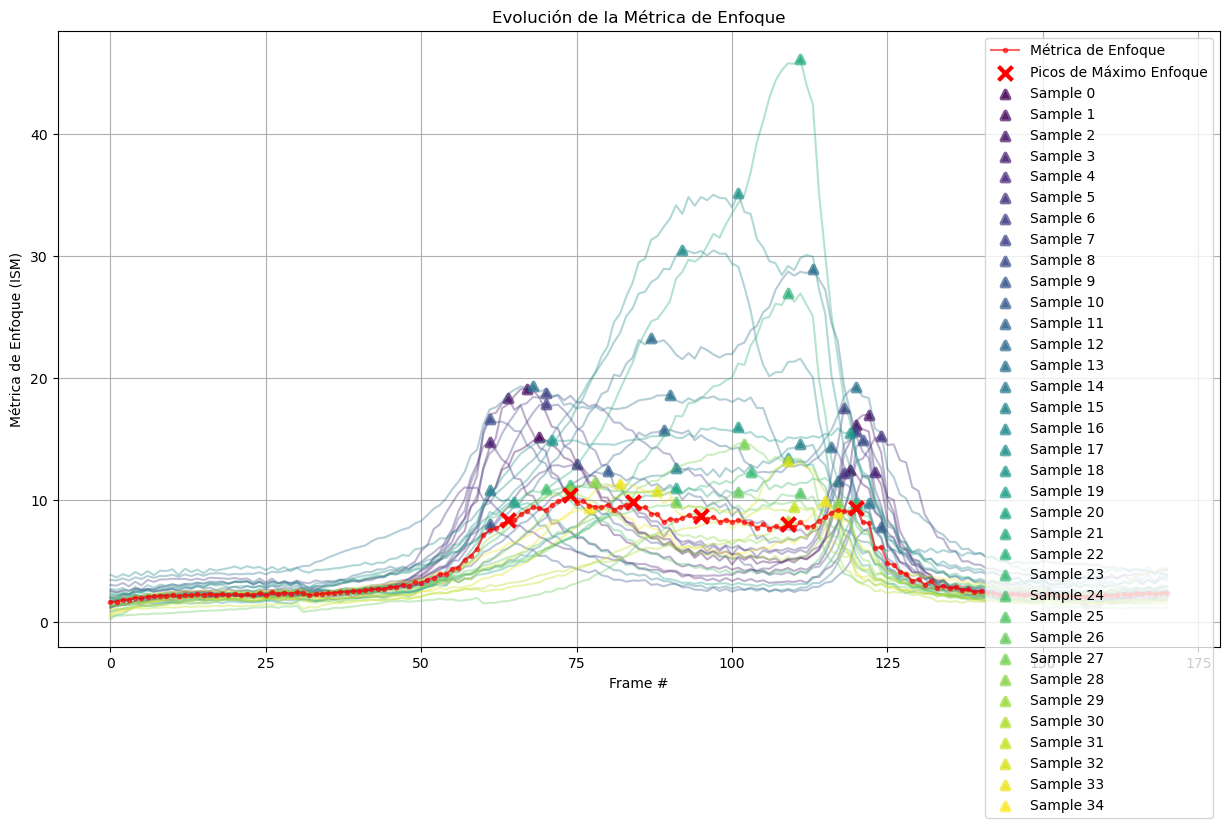

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 74 con un valor de 10.39553


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 9.12036
Threshold del 80% de los picos: 7.29629


In [ ]:
N, M = matrix
output_path = f'alt_focus_matrix_{N}x{M}.mp4'
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 7x5
Video exportado correctamente en: alt_focus_matrix_7x5.mp4


### Matriz 9x13

In [ ]:
matrix = 9, 13

Algoritmo alternativo
La imágen será procesada según la Matriz 9x13
Completa la creación de regiones

Procesando frame 171/171
Picos para el 0 detectados en el frame: [ 69 119]
Picos para el 1 detectados en el frame: [69]
Picos para el 2 detectados en el frame: [68]
Picos para el 3 detectados en el frame: [67]
Picos para el 4 detectados en el frame: [ 66 120]
Picos para el 5 detectados en el frame: [ 64 122]
Picos para el 6 detectados en el frame: [ 64 122]
Picos para el 7 detectados en el frame: [ 61 122]
Picos para el 8 detectados en el frame: [61]
Picos para el 9 detectados en el frame: [ 60 123]
Picos para el 10 detectados en el frame: [ 59 125]
Picos para el 11 detectados en el frame: [ 59 126]
Picos para el 12 detectados en el frame: [124]
Picos para el 13 detectados en el frame: [ 74 119]
Picos para el 14 detectados en el frame: [ 69 118]
Picos para el 15 detectados en el frame: [ 71 119]
Picos para el 16 detectados en el frame: [ 70 119]
Picos para el 17 detectados en el frame:

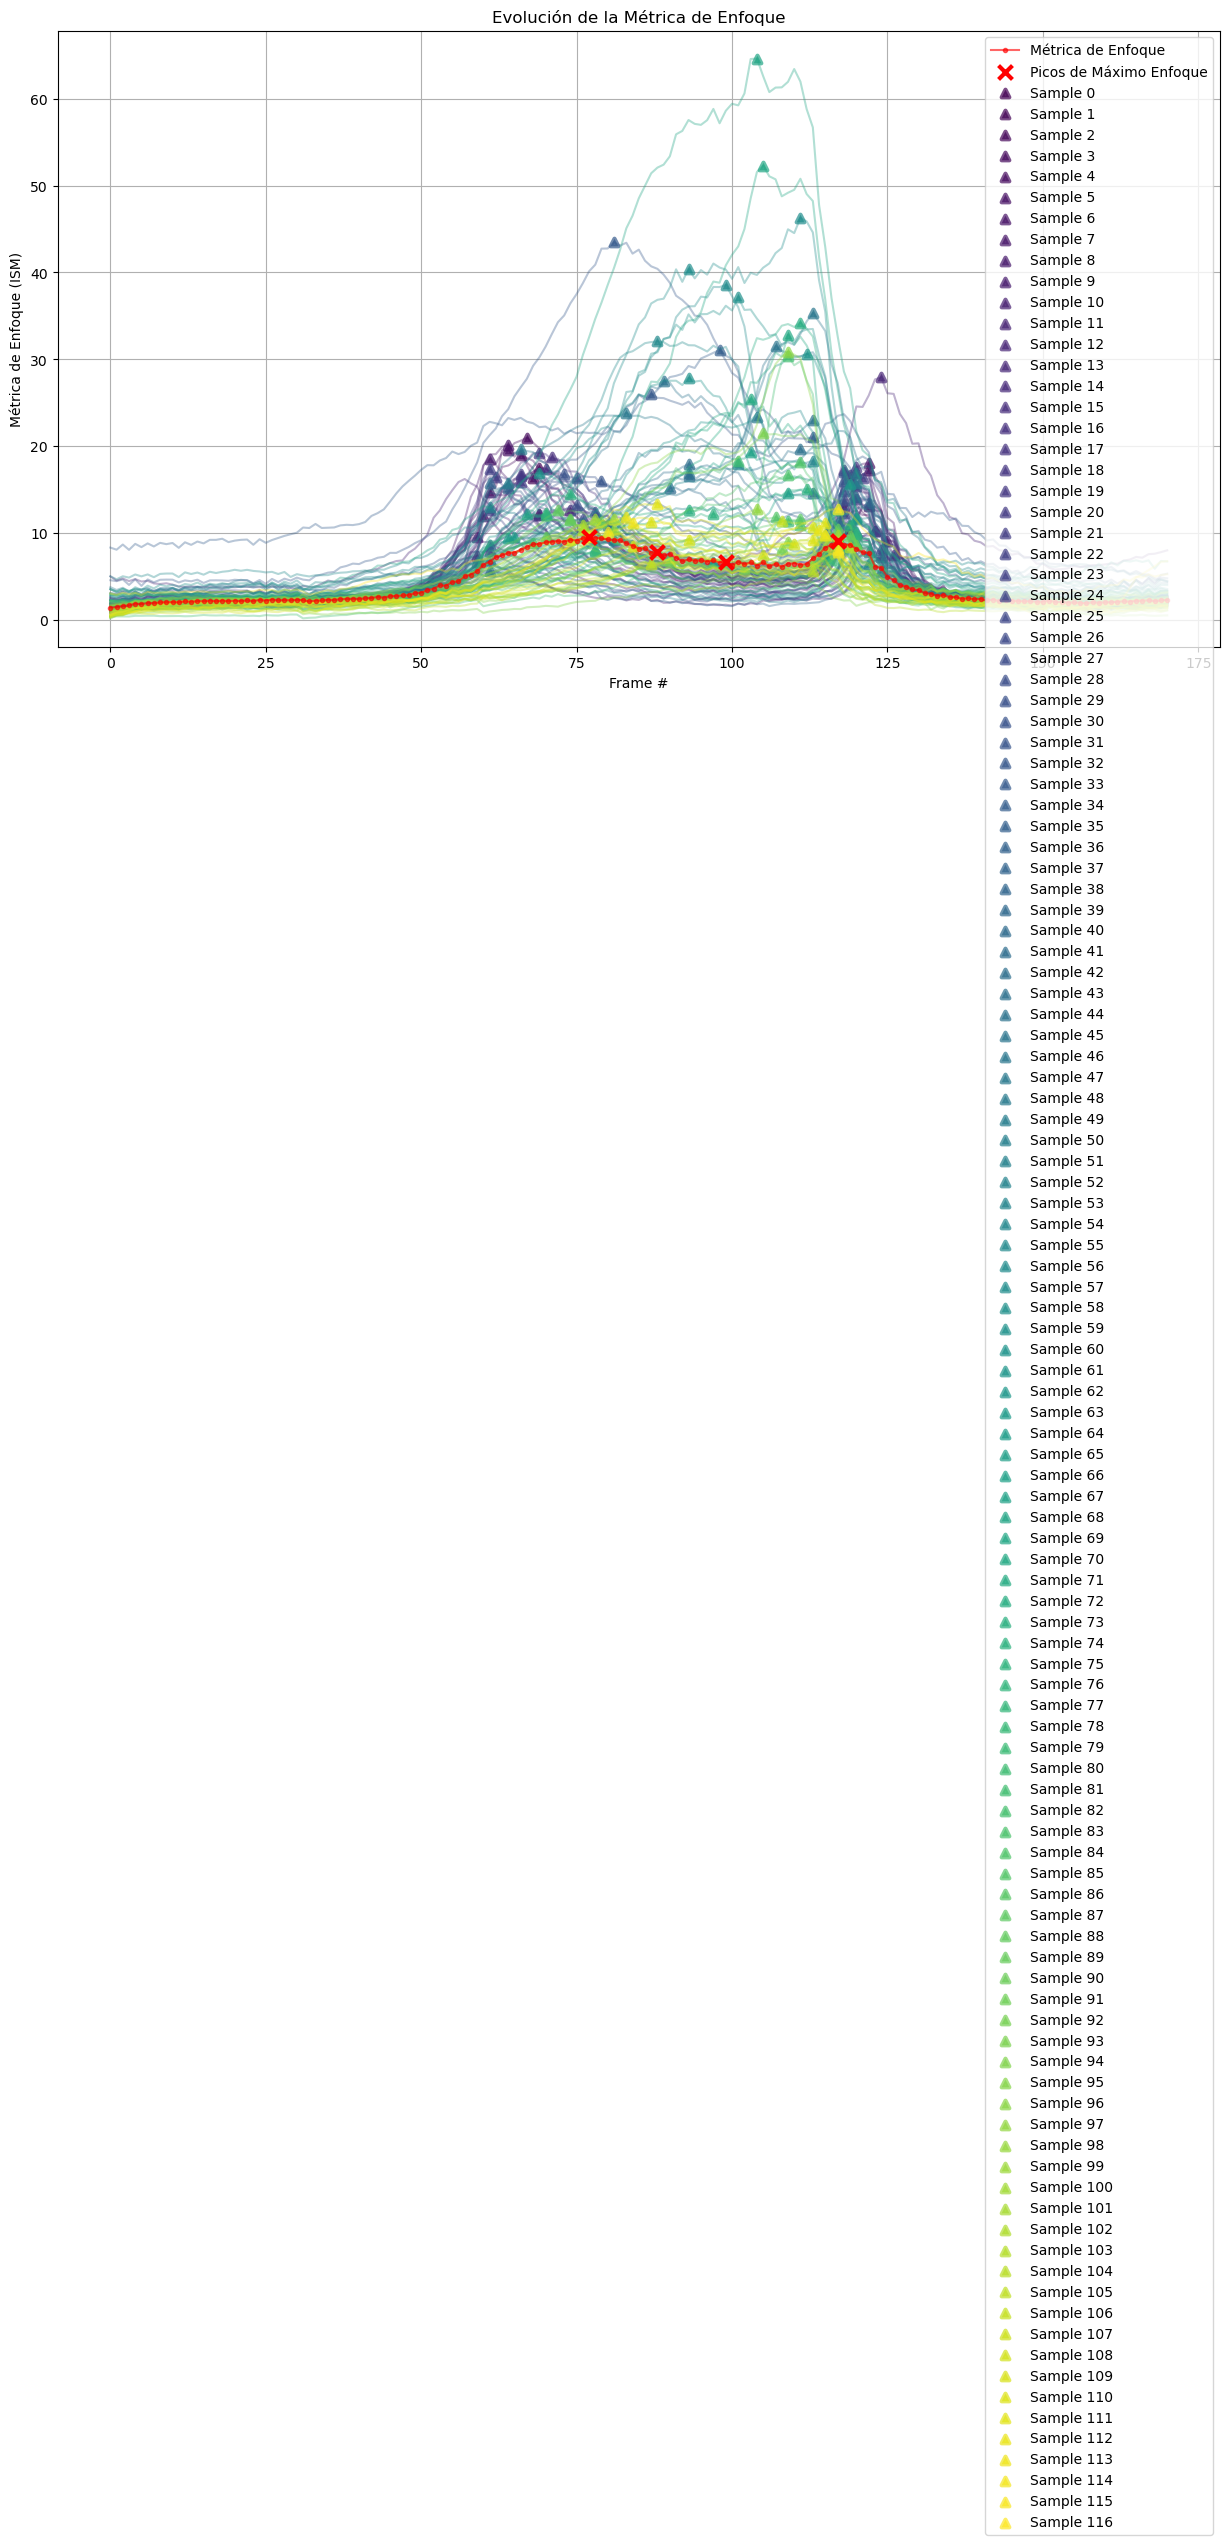

In [ ]:
video_path = 'focus_video.mov'

ism_metrics = process_Video_Focus(video_path, matrix)

focus_peaks = graph_Metrics(ism_metrics)

In [ ]:
ism_average = np.median(np.transpose(ism_metrics), axis=1)

In [ ]:
max_peak_index = focus_peaks[np.argmax(ism_average[focus_peaks])]
max_peak_value = ism_average[max_peak_index]
print("Punto de máximo enfoque")
print(f"Frame {max_peak_index} con un valor de {max_peak_value:.5f}")

Punto de máximo enfoque
Frame 77 con un valor de 9.48707


In [ ]:
mean = np.mean(ism_average[focus_peaks])
threshold = 80 /100  # Umbral de los picos (%)
level = mean * threshold
print(f"Media de enfoque: {mean:.5f}")
print(f"Threshold del {threshold*100:.0f}% de los picos: {level:.5f}")

Media de enfoque: 8.27075
Threshold del 80% de los picos: 6.61660


In [ ]:
N, M = matrix
output_path = f'alt_focus_matrix_{N}x{M}.mp4' 
print("Medición de enfoque sobre todo el frame.")
export_Video(ism_average, output_path=output_path, threshold_focus=level, matrix=matrix)

Medición de enfoque sobre todo el frame.
Propiedades del video: 640x360px, 29fps
La imágen será procesada según la Matriz 9x13
Video exportado correctamente en: alt_focus_matrix_9x13.mp4
